# Explore

This file demonstrates the code

In [1]:
import dependencies
import soft_dependencies

Python Version 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
Numpy Version 1.21.5
Cvxpy Version 1.2.0
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import line_profiler
import memory_profiler

np.set_printoptions(precision=3, suppress=True)
%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

In [7]:
from Scripts.generate_data import generate_Ys, generate_sparse_posdef_matrix
from Scripts.scBiGLasso import scBiGLasso
from Scripts.utilities import generate_confusion_matrices
from Scripts.utilities import precision, recall, accuracy

## Explore Results
How good is it?  Does it work like we expect?

In [20]:
p=20
n=20
Psi_gen, Theta_gen, Ys = generate_Ys(
    m=100,
    p=p,
    n=n,
    expected_nonzero_psi=n**2 / 5,
    expected_nonzero_theta=p**2 / 5,
    structure="Kronecker Sum"
)
Ys.shape

(100, 20, 20)

In [40]:
n=4
generate_sparse_posdef_matrix(
    n=n,
    expected_nonzero=n**2 / 5,
    size=2
)

array([[[ 0.916, -0.   , -0.   , -0.   ],
        [-0.   ,  0.967, -0.   ,  0.   ],
        [-0.   , -0.   ,  0.87 , -0.   ],
        [-0.   ,  0.   , -0.   ,  1.247]],

       [[ 0.916, -0.   , -0.042, -0.016],
        [-0.   ,  0.967, -0.   ,  0.   ],
        [-0.042, -0.   ,  0.87 , -0.024],
        [-0.016,  0.   , -0.024,  1.247]]])

In [5]:
Psi, Theta = scBiGLasso(
    N = 100,
    eps = 10e-4,
    Ys = Ys,
    beta_1 = 0.7, #For perfect precision: .4 for Kron Prod, .7 for Kron Sum
    beta_2 = 0.7
)
print("===Psi===")
print(Psi_cm := generate_confusion_matrices(Psi, Psi_gen, mode='Negative'))
print(
    f"{precision(Psi_cm)=:.3f}",
    f"\n{recall(Psi_cm)=:.3f}",
    f"\n{accuracy(Psi_cm)=:.3f}"
)
print("\n==Theta==")
print(Theta_cm := generate_confusion_matrices(Theta, Theta_gen, mode='Negative'))
print(
    f"{precision(Theta_cm)=:.3f}",
    f"\n{recall(Theta_cm)=:.3f}",
    f"\n{accuracy(Theta_cm)=:.3f}"
)

===Psi===
[[  2.   2.]
 [ 50. 326.]]
precision(Psi_cm)=0.500 
recall(Psi_cm)=0.038 
accuracy(Psi_cm)=0.863

==Theta==
[[  6.   0.]
 [ 32. 342.]]
precision(Theta_cm)=1.000 
recall(Theta_cm)=0.158 
accuracy(Theta_cm)=0.916


## Explore Performance
How fast is it?  How much memory does it use?

<font size=-1>_You have to run these cells yourself to see results_</font>

In [166]:
# Time to generate data
from Scripts.generate_data import multi_norm, matrix_normal_ks
kwargs_gen = {
    'm': 100,
    'p': (p:=100),
    'n': (n:=100),
    'structure': 'Kronecker Sum',
    'expected_nonzero_psi': n**2 / 5,
    'expected_nonzero_theta': p**2 / 5
}
%lprun -f generate_Ys -f multi_norm -f matrix_normal_ks generate_Ys(**kwargs_gen)

In [172]:
# Time to run scBiGLasso
from Scripts.scBiGLasso import _scBiGLasso_internal, _calculate_A
from Scripts.utilities import LASSO_sklearn

kwargs = {
    "N": 100,
    "eps": 10e-3,
    "Ys": Ys,
    "beta_1": 0.7,
    "beta_2": 0.7
}
%lprun -f scBiGLasso -f _scBiGLasso_internal -f LASSO_sklearn -f _calculate_A scBiGLasso(**kwargs)

In [9]:
# Info on memory usage
# Honestly, the results don't seem useful?
%mprun -f scBiGLasso -f _scBiGLasso_internal -f LASSO_sklearn -f _calculate_A scBiGLasso(**kwargs)

# Explore Results
How does it do for different $\beta$?  For different densities?

<font size=-1>_(May take a while to run)_</font>

In [8]:
from Scripts.experiments import experiment_1

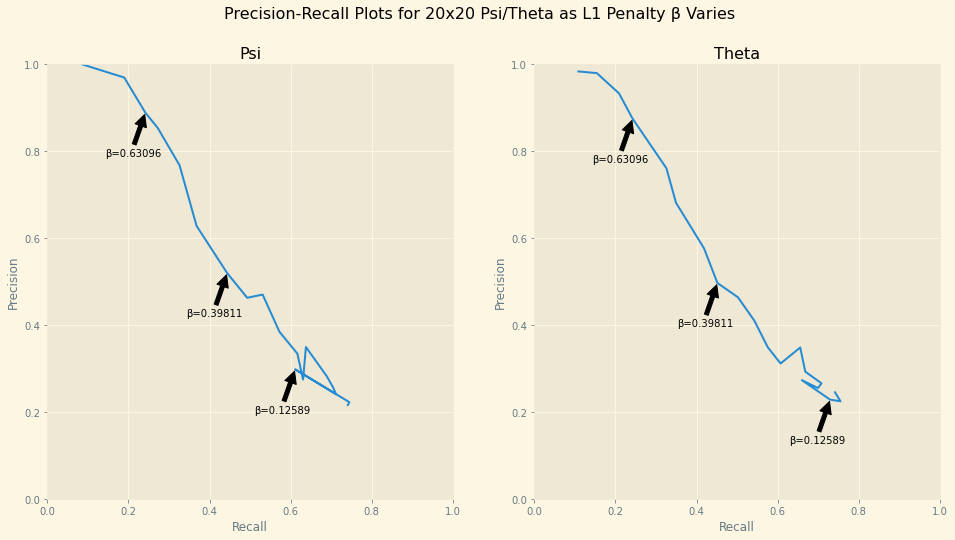

/Users/baileyandrew/Desktop/Python Notebooks.nosync/Research/scBiGLasso Implementation/Python Implementation/Scripts/utilities.py:121: RuntimeWarning: invalid value encountered in double_scalars
  return cm[0, 0] / (cm[0, 0] + cm[0, 1])


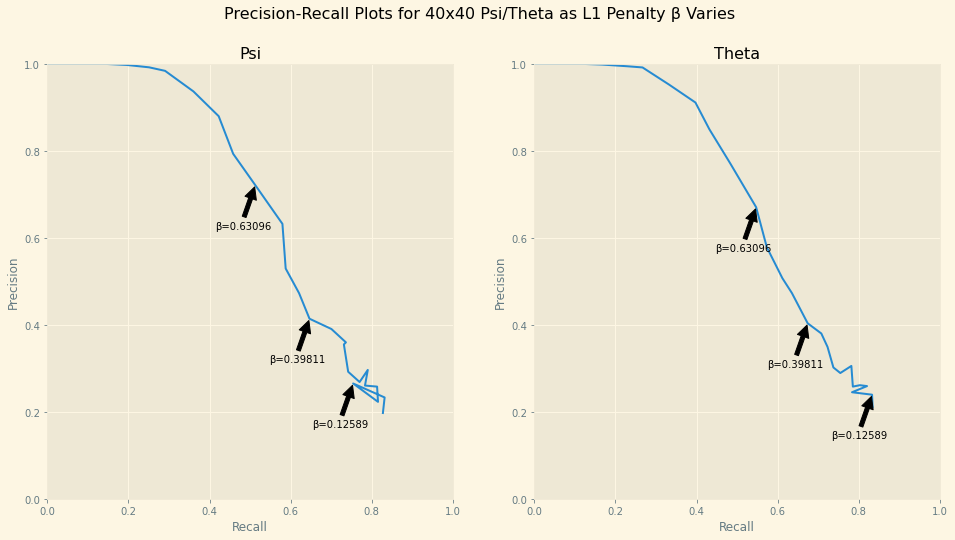

/Users/baileyandrew/Desktop/Python Notebooks.nosync/Research/scBiGLasso Implementation/Python Implementation/Scripts/utilities.py:121: RuntimeWarning: invalid value encountered in double_scalars
  return cm[0, 0] / (cm[0, 0] + cm[0, 1])


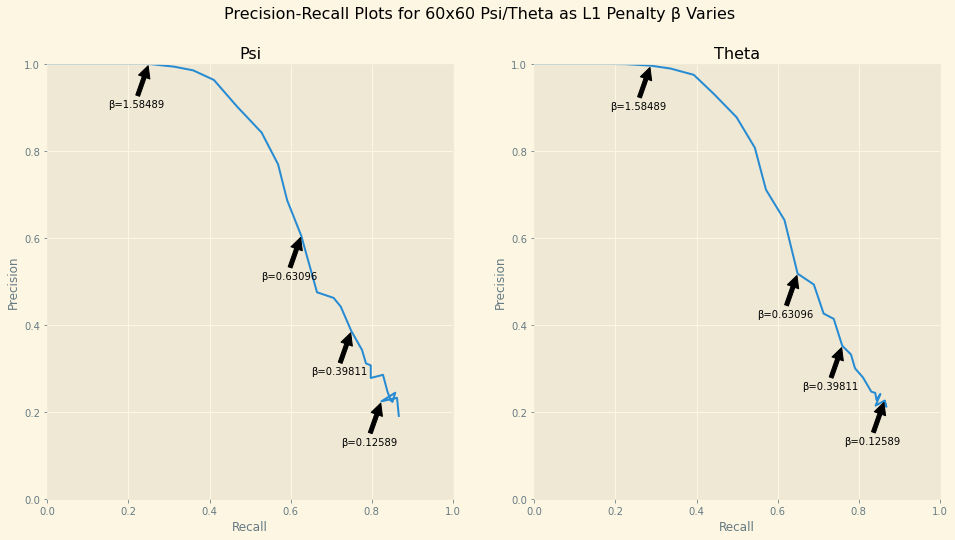

/Users/baileyandrew/Desktop/Python Notebooks.nosync/Research/scBiGLasso Implementation/Python Implementation/Scripts/utilities.py:121: RuntimeWarning: invalid value encountered in double_scalars
  return cm[0, 0] / (cm[0, 0] + cm[0, 1])


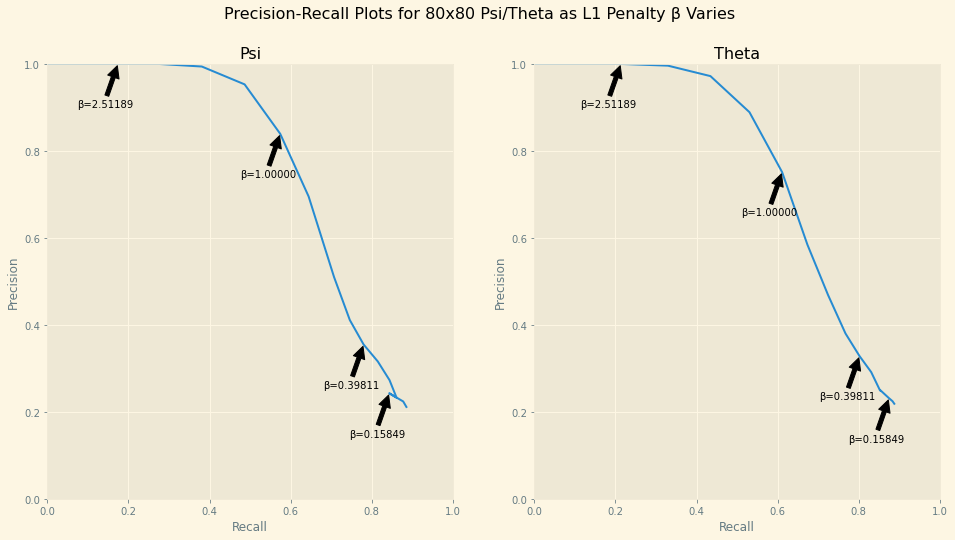

/Users/baileyandrew/Desktop/Python Notebooks.nosync/Research/scBiGLasso Implementation/Python Implementation/Scripts/utilities.py:121: RuntimeWarning: invalid value encountered in double_scalars
  return cm[0, 0] / (cm[0, 0] + cm[0, 1])


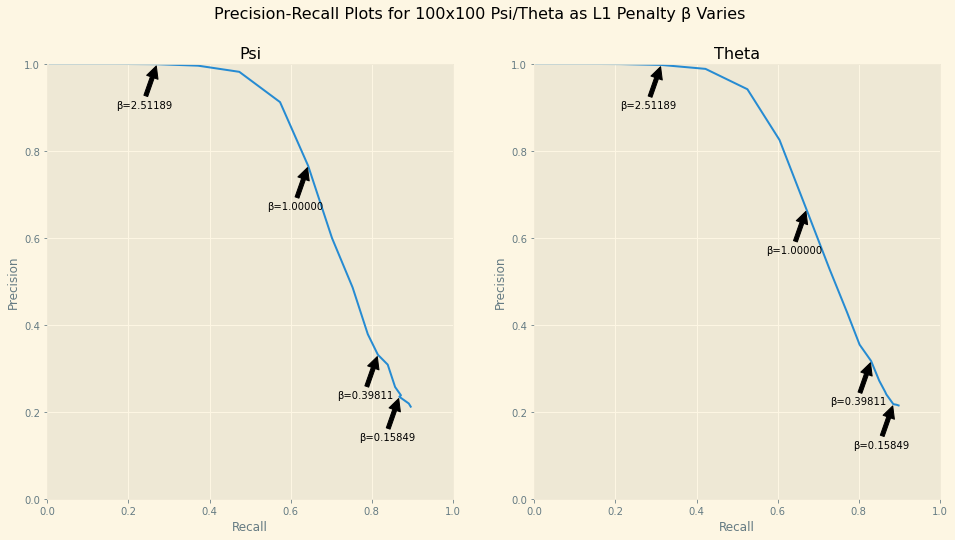

In [165]:
# How does choice of betas and matrix size affect results?
sizes = [20, 40, 60, 80, 100]
betas = [
    10**np.arange(-1, 0, 0.05), # 20
    10**np.arange(-1, 1, 0.05), # 40
    10**np.arange(-1, 1, 0.05), # 60
    10**np.arange(-1, 1, 0.1), # 80
    10**np.arange(-1, 1, 0.1) # 100
]
interesting_indices = [
    [2, 12, 16],
    [2, 12, 16],
    [2, 12, 16, 24],
    [2, 6, 10, 14],
    [2, 6, 10, 14]
]
for idx, size in enumerate(sizes):
    fig, axs = experiment_1(
        100,
        size,
        betas[idx],
        attempts=25,
        indices_to_highlight=interesting_indices[idx]
    )
    fig.savefig(f'../Plots/Vary-Sizes-Experiment/Precision-Recall-Vary-Sizes-{size}')
    display(fig) # Force figure to display NOW (`fig.show()` does not do this)
    plt.close(fig) # Suppress double-displaying the figure
    